In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [11]:
# Taken from my own CV course assignment - https://github.com/KhadgaA/Camera-Calibration-and-Stereo/blob/main/M23CSA003_qu1.py 
class Custom_CV:
    @staticmethod
    def padding(img, kernelsize, mode="reflect"):
        # padding
        padx = kernelsize[0] - 1
        pady = kernelsize[1] - 1
        padded_img = np.zeros((img.shape[0] + padx, img.shape[1] + pady))
        padded_img[
            padx // 2 : img.shape[0] + padx // 2, pady // 2 : img.shape[1] + pady // 2
        ] = img

        if mode == "reflect":
            if pady > 0:
                padded_img[:, 0 : pady // 2] = padded_img[:, slice(pady // 2, 0, -1)]
                padded_img[:, -pady // 2 :] = padded_img[
                    :, slice(-pady // 2 - 1, -1, 1)
                ]

            if padx > 0:
                padded_img[0 : padx // 2, :] = padded_img[slice(padx // 2, 0, -1), :]
                padded_img[-padx // 2 :, :] = padded_img[
                    slice(-padx // 2 - 1, -1, 1), :
                ]
        elif mode == "zero":
            pass
        return padded_img

    @staticmethod
    def apply_convolution(img, kernel):
        kernelsize_x, kernelsize_y = kernel.shape
        image_height, image_width = img.shape
        padded_img = Custom_CV.padding(img, kernel.shape)
        conv_img = np.zeros_like(img)

        # convolution
        for i in range(kernelsize_x):
            for j in range(kernelsize_y):
                conv_img += (
                    padded_img[i : image_height + i, j : image_width + j] * kernel[i, j]
                )
        return conv_img

    @staticmethod
    def sobel(img, dir):
        if dir == "x":
            # mn complexity
            # kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
            # seperate kernels => m+n complexity
            kernelx = np.array([[-1, 0, 1]])
            kernely = np.array([[1], [2], [1]])
        else:
            # kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
            kernelx = np.array([[1, 2, 1]])
            kernely = np.array([[1], [0], [-1]])

        convx = Custom_CV.apply_convolution(img, kernelx)
        convxy = Custom_CV.apply_convolution(convx, kernely)
        return convxy

    @staticmethod
    def gaussian_blur(img, ksize, sigma):
        if sigma == 0:
            sigma = 0.3 * ((ksize - 1) * 0.5 - 1) + 0.8
        kernelx = np.zeros((ksize,))
        for i in range(ksize):
            kernelx[i] = np.exp(-((i - 1) ** 2) / (2 * sigma**2))
        kernelx = kernelx.reshape(1, -1)
        kernely = kernelx.reshape(-1, 1)
        convx = Custom_CV.apply_convolution(img, kernelx)
        convxy = Custom_CV.apply_convolution(convx, kernely)
        return convxy
    @staticmethod
    def non_max_suppression(dst, kernelsize):
        padded_dst = Custom_CV.padding(dst, kernelsize)
        for i in range(dst.shape[0]):
            for j in range(dst.shape[1]):
                if dst[i, j] != np.max(
                    padded_dst[i : i + kernelsize[0], j : j + kernelsize[1]]
                ):
                    dst[i, j] = 0
        return dst

In [12]:
img = cv.imread("./Edge-detection/03-lalitha-mahal.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = np.float32(gray)

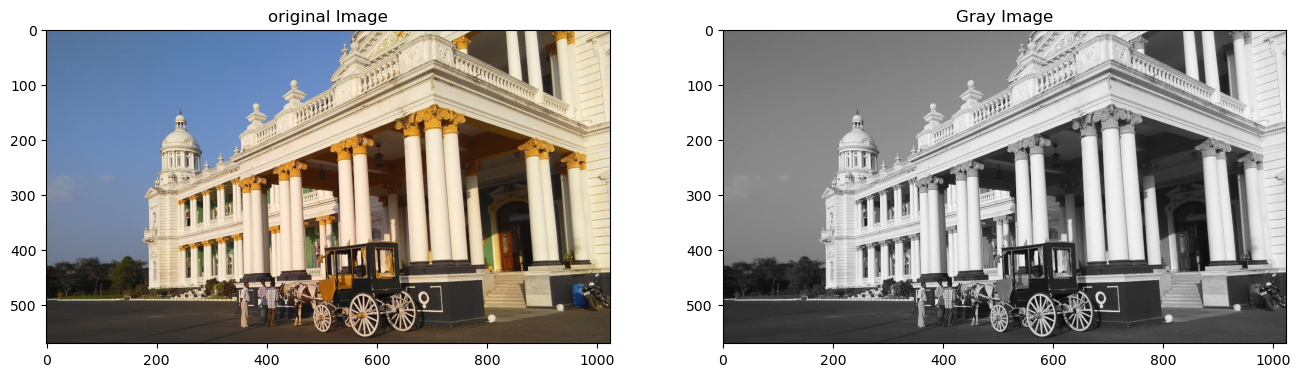

In [20]:
plt.figure(figsize=(16,18))
plt.subplot(121)
plt.title("original Image")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.subplot(122)
plt.title("Gray Image")
plt.imshow(gray,'gray')

Text(0.5, 1.0, 'DoG Image')

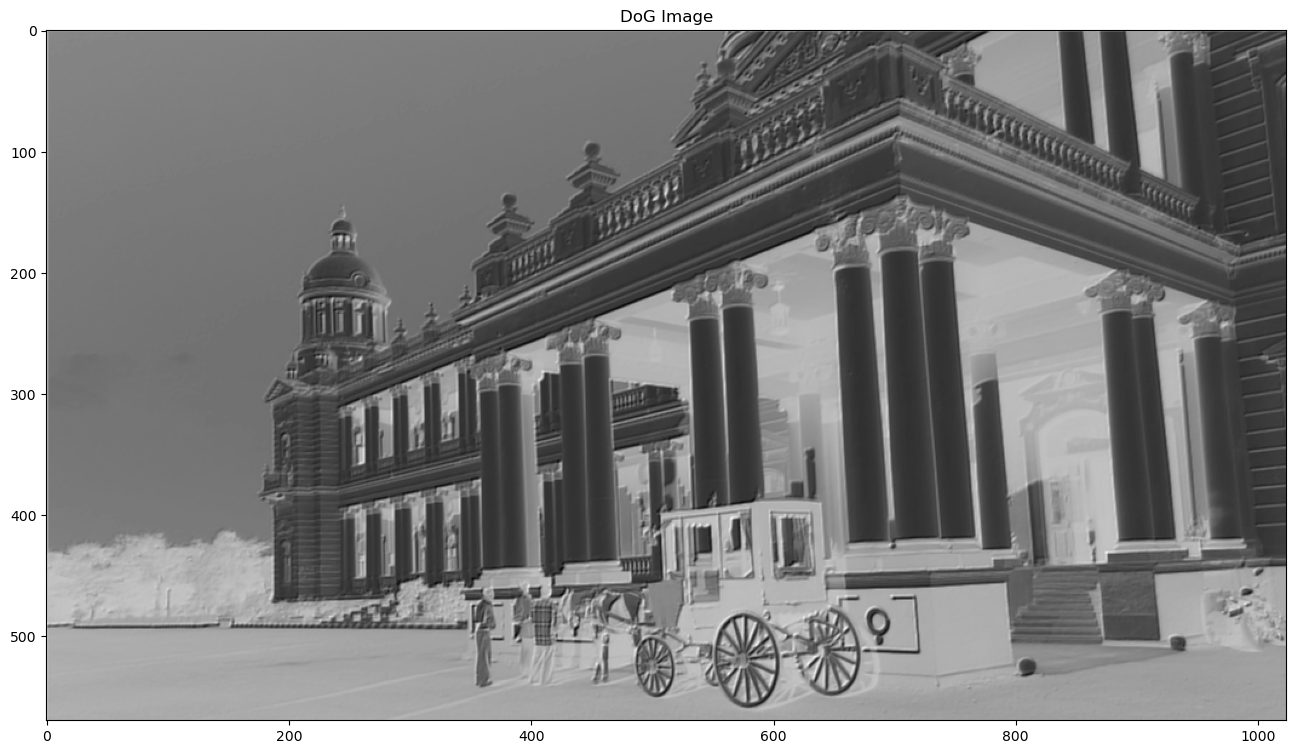

In [24]:
# DoG
GB1 = Custom_CV.gaussian_blur(img=gray, ksize=3, sigma=0) #if sigma is 0, it is automatically calculated based in Ksize.
GB2 = Custom_CV.gaussian_blur(img=gray, ksize=5, sigma=0)

DoG_img = GB1 - GB2
plt.figure(figsize=(16,18))
plt.imshow(DoG_img,'gray')
plt.title("DoG Image")


In [218]:
# Sobel Filters
ksize = 3
sobelx = Custom_CV.sobel(gray, "x")
sobely = Custom_CV.sobel(gray, "y")

sobelx[np.isclose(sobelx, 0, atol=50)] = 0.0

sobely[np.isclose(sobely, 0, atol=50)] = 0.0

In [219]:
# https://dsp.stackexchange.com/questions/12821/detecting-edges-oriented-at-certain-angle
def CreateDirectionalEdges(Ix,Iy,angle):
    """
        Ix is Intensity of x- axis edges. i.e., sobel-y 
        
        Iy is Intensity of y- axis edges. i.e., sobel-x 
    """
    theta = (angle/180) *np.pi
    I_theta = Ix*np.cos(theta) + Iy*np.sin(theta)
    return I_theta

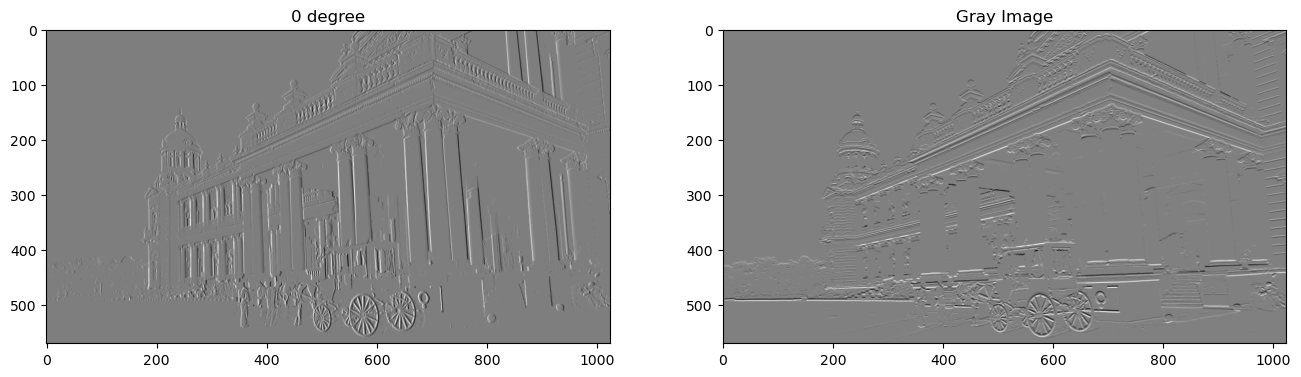

In [220]:
plt.figure(figsize=(16,18))
plt.subplot(121)
plt.title("0 degree")
plt.imshow(sobelx,'gray')
plt.subplot(122)
plt.title("Gray Image")
plt.imshow(sobely,'gray')

In [221]:
edge_0 = sobely #Sobely is gradient along y direction, i.e., horizontal edge, whih is 0 degrees wrto x axis.
edge_45 = CreateDirectionalEdges(sobely,sobelx,angle=45)
edge_90 = sobelx
edge_135 = CreateDirectionalEdges(sobely,sobelx,angle=135)
# edge_0 = np.tanh(edge_0)
# edge_45 = np.tanh(edge_45)
# edge_90 = np.tanh(edge_90)
# edge_135 = np.tanh(edge_135)

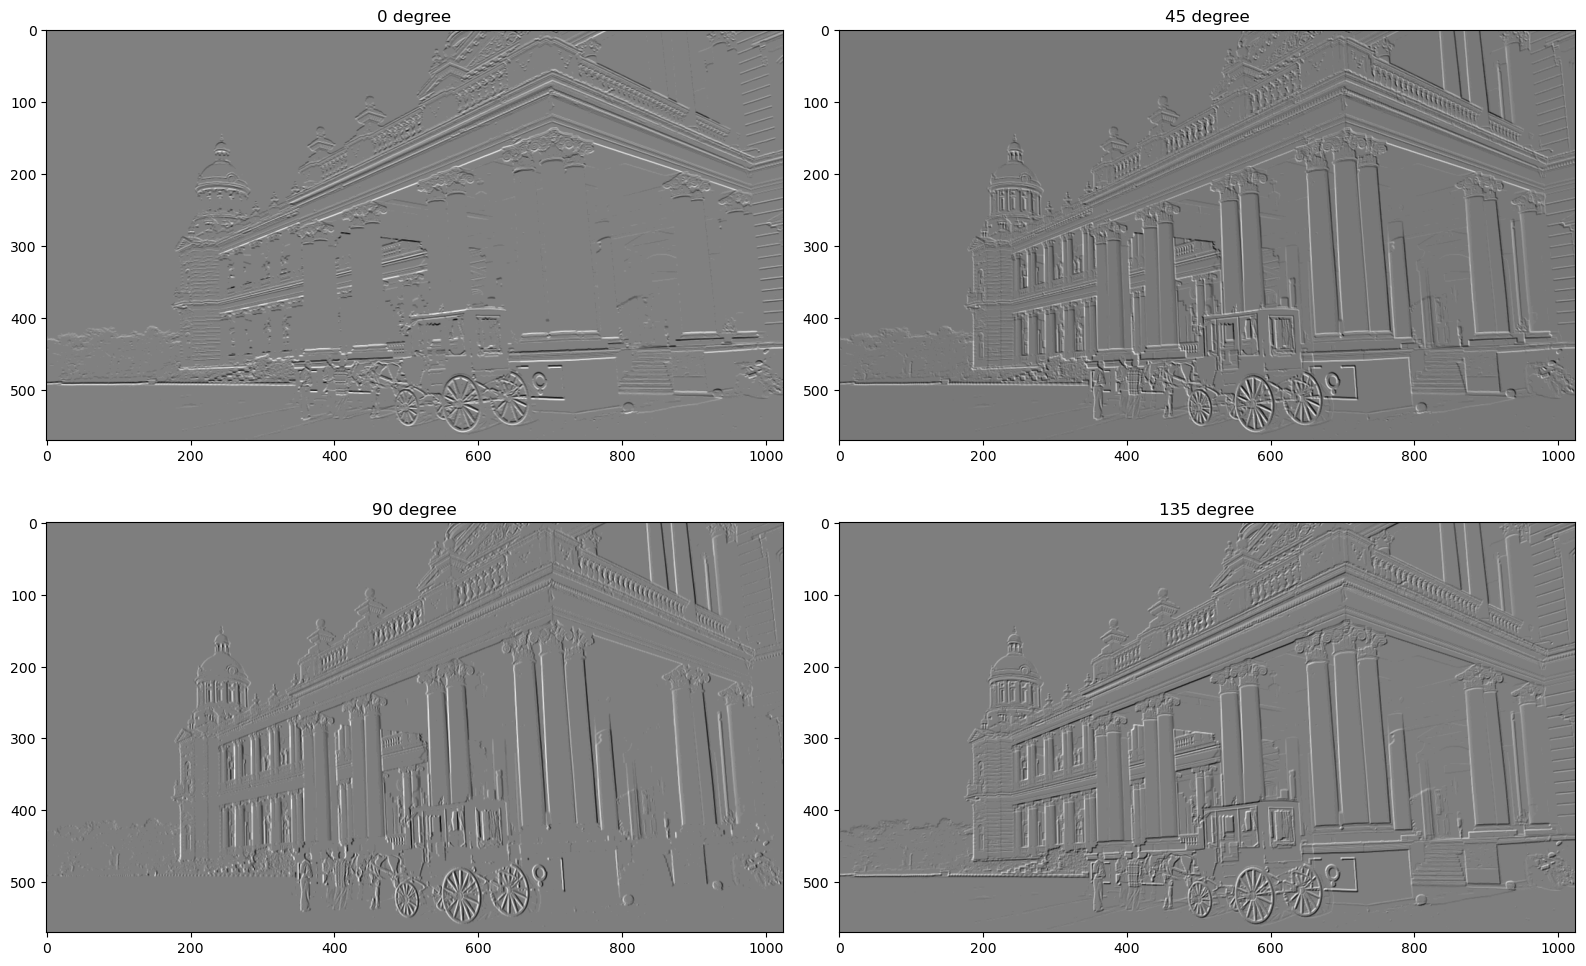

In [222]:

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

axs[0, 0].imshow(edge_0, 'gray')
axs[0, 0].set_title("0 degree")

axs[0, 1].imshow(edge_45, 'gray')
axs[0, 1].set_title("45 degree")

axs[1, 0].imshow(edge_90, 'gray')
axs[1, 0].set_title("90 degree")

# Set super low values to zero
# edge_135[np.isclose(edge_135, 0, atol=0.2)] = 0.0
axs[1, 1].imshow(edge_135, 'gray')
axs[1, 1].set_title("135 degree")

fig.tight_layout()
plt.show()

In [223]:
# Normalization (Winner-Takes-All)
# normalized_edges = np.zeros_like(edge_0)
normalized_edges = 4 * np.maximum.reduce([edge_0,edge_45,edge_90,edge_135])/(1e-4 + np.add.reduce([edge_0,edge_45,edge_90,edge_135]))
# normalized_edges = np.tanh(normalized_edges) # Scaling to -1.0 to 1.0

In [224]:
normalized_edges.max(),normalized_edges.min()

(132531.89, -135480.38)

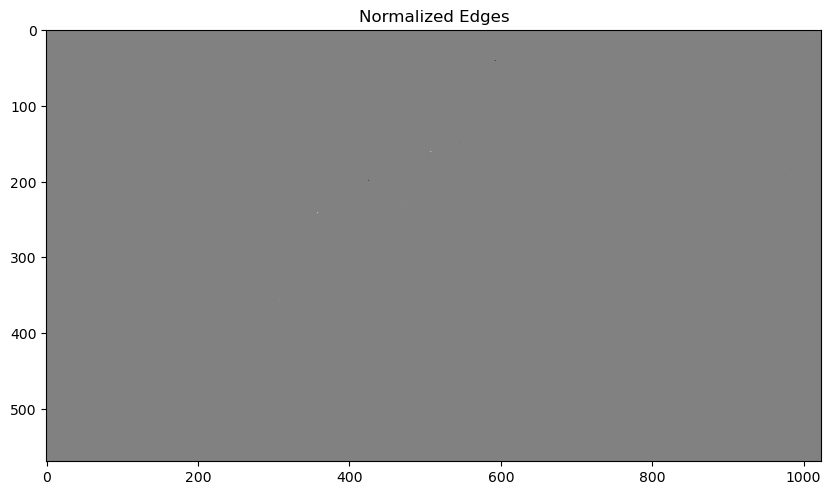

In [225]:
plt.figure(figsize=(10,6))
plt.title("Normalized Edges")
plt.imshow(normalized_edges,'gray')


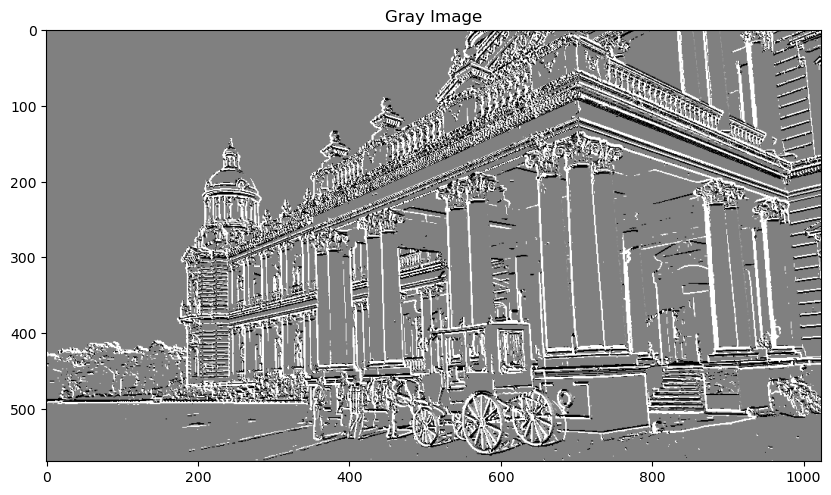

In [226]:
#thresholding
plt.figure(figsize=(10,6))
# plt.subplot(122)
plt.title("Gray Image")
# plt.imshow(np.clip(normalized_edges,a_min=-255,a_max=np.median(np.stack([edge_0,edge_45,edge_90,edge_135]),axis=0)),'gray')

plt.imshow(np.clip(normalized_edges,a_min=-1,a_max=1),'gray')